# 인물을 대상으로 실행해봅시다.

In [38]:
import os
import cv2
import numpy as np
import urllib
import tarfile


from glob import glob
from matplotlib import pyplot as plt
import tensorflow as tf

img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_image.png'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1440, 1080, 3)


# 딥랩 모델 준비하기.

In [39]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

# 시전에 학습된 가중치를 불러오기

In [40]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [41]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1440, 1080, 3) (513, 384, 3) 15


In [42]:
# 제공하는 라벨 종류는 아래와 같습니다.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

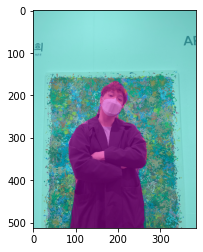

In [43]:
# 사진 중에서 사람의 라벨, 즉 15를 가진 영역만 검출해 봅시다.
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_COOL)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 근데 내가 생각해도 얼굴이 많이 크게 나왔네요. 화면이 purple. 

## 세스먼테이션 결과를 원래 크기로 복원해보기

원본 이미지의 크기: (1080, 1440)
변형 마스크의 크기: (513, 384)


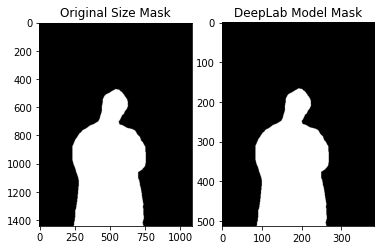

In [44]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'원본 이미지의 크기: {img_orig.shape[:2][::-1]}\n변형 마스크의 크기: {img_mask.shape}')
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 배경을 흐르게 하기. 

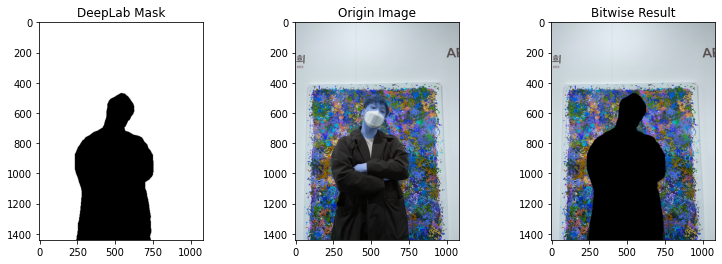

In [45]:
#세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

fig = plt.figure(figsize=(13, 4)) 

ax = plt.subplot(1,3,1)
plt.imshow(img_bg_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Mask')

ax = plt.subplot(1,3,2)
plt.imshow(img_orig, cmap=plt.cm.binary_r)
ax.set_title('Origin Image')

ax = plt.subplot(1,3,3)
plt.imshow(img_bg, cmap=plt.cm.binary_r)
ax.set_title('Bitwise Result')

plt.show()

#### 근데.. 왜 내 굴이 흐린게 아니고 ㅋㅋ 그냥 없고.. 다른 사진은 내가 스퍼프네 ㅋㅋ 

Text(0.5, 1.0, 'Blur Processing')

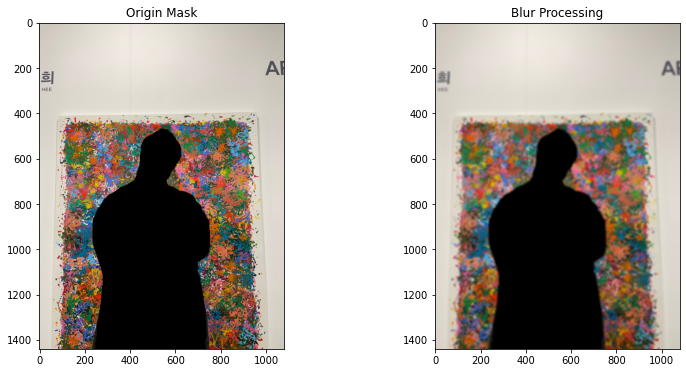

In [46]:
# 이 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있습니다.
img_bg_blur = cv2.blur(img_bg, (12,12))

fig = plt.figure(figsize=(13, 6)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Origin Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Blur Processing')

#### ㅋㅋㅋ 열굴이 사진 화면을 다 커버해서 대부분 왼쪽 Y 자표 1500-2000 밖에 안보이네 ㅋㅋ

## 흐린 배경과 원본 영상 합성하기

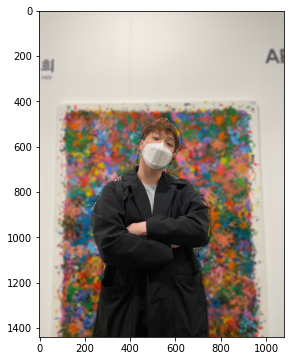

In [47]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
fig = plt.figure(figsize=(16, 6)) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 크로마키사진 제작하기

In [48]:
aiffel_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/CHINA.png'#
aiffel_orig = cv2.imread(aiffel_path) 
aiffel_orig = aiffel_orig[:, 200:584]

img_mask = img_mask[100:513, :]
_, img_mask = cv2.threshold(img_mask, 128, 255, cv2.THRESH_BINARY)

print("이미지 마스크 사이즈: ", img_mask.shape)
print("에펠탑 이미지 사이즈: ", aiffel_orig.shape)

이미지 마스크 사이즈:  (413, 384)
에펠탑 이미지 사이즈:  (1707, 384, 3)


In [49]:
# 이미지 배경 사이즈 줄이기
img_bg_mask = cv2.resize(img_bg_mask, img_mask.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)


resize_origin = cv2.resize(img_orig, img_mask.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
aiffel_bg = cv2.bitwise_and(aiffel_orig, img_bg_mask)

fig = plt.figure(figsize=(13, 4)) 

ax = plt.subplot(1,2,1)
plt.imshow(img_bg_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Mask')

ax = plt.subplot(1,2,2)
plt.imshow(aiffel_bg, cmap=plt.cm.binary_r)
ax.set_title('Origin Image')

error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv/modules/core/src/arithm.cpp:232: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


In [50]:
ut_concat = np.where(img_bg_mask==0,resize_origin, aiffel_bg)

plt.figure(figsize=(16,6))
plt.imshow(cv2.cvtColor(out_concat,cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)

NameError: name 'aiffel_bg' is not defined

# BIGFOOT VS KINGKONG !

(1800, 1200, 3)
(1124, 742, 3)


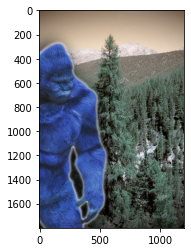

In [59]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/'
bigfoot_orig = cv2.imread(os.path.join(img_path,'BIGFOOT.png')) 
kingkong_orig = cv2.imread(os.path.join(img_path,'KINGKONG.png')) 
print (bigfoot_orig.shape)
print (kingkong_orig.shape)
plt.imshow(bigfoot_orig)

In [60]:
bigfoot_resized, bigfoot_map = MODEL.run(bigfoot_orig)
print (bigfoot_orig.shape, bigfoot_resized.shape, bigfoot_map.max())

(1800, 1200, 3) (513, 341, 3) 8


In [61]:
kingkong_resized, kingkong_map = MODEL.run(kingkong_orig)
print (kingkong_orig.shape, kingkong_resized.shape, kingkong_map.max())

(1124, 742, 3) (513, 338, 3) 8


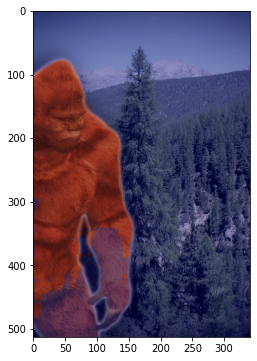

In [62]:
bigfoot_show = bigfoot_resized.copy()
bigfoot_map = np.where(bigfoot_map == 8, 8, 0)
bigfoot_mask = bigfoot_map * (255/bigfoot_map.max()) # 255 normalization
bigfoot_mask = bigfoot_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(bigfoot_mask, cv2.COLORMAP_JET)
bigfoot_show = cv2.addWeighted(bigfoot_show, 0.6, color_mask, 0.35, 0.0)

fig = plt.figure(figsize=(16, 6))
plt.imshow(cv2.cvtColor(bigfoot_show, cv2.COLOR_BGR2RGB))
plt.show()

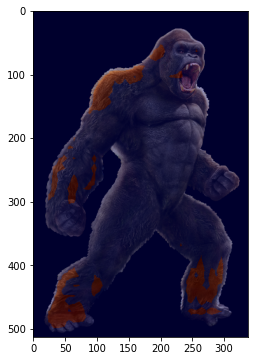

In [63]:
kingkong_show = kingkong_resized.copy()
kingkong_map = np.where(kingkong_map == 8, 8, 0)
kingkong_mask = kingkong_map * (255/kingkong_map.max()) # 255 normalization
kingkong_mask = kingkong_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(kingkong_mask, cv2.COLORMAP_JET)
kingkong_show = cv2.addWeighted(kingkong_show, 0.6, color_mask, 0.35, 0.0)

fig = plt.figure(figsize=(16, 6))
plt.imshow(cv2.cvtColor(kingkong_show, cv2.COLOR_BGR2RGB))
plt.show()

bigfoot 마스크 크기: (742, 1124)
kingkong 마스크 크기: (513, 338)


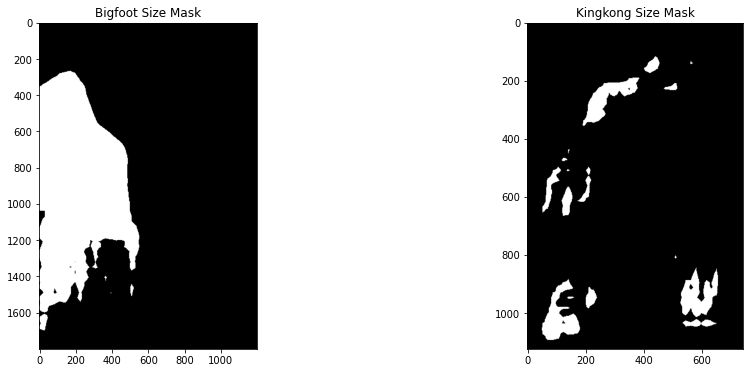

In [64]:
# 마스크 뽑아내기
bigfoot_mask_up = cv2.resize(bigfoot_mask, bigfoot_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, bigfoot_mask_up = cv2.threshold(bigfoot_mask_up, 128, 255, cv2.THRESH_BINARY)

kingkong_mask_up = cv2.resize(kingkong_mask, kingkong_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, kingkong_mask_up = cv2.threshold(kingkong_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'bigfoot 마스크 크기: {kingkong_orig.shape[:2][::-1]}\nkingkong 마스크 크기: {kingkong_mask.shape}')

fig = plt.figure(figsize=(16, 6))
ax = plt.subplot(1,2,1)
plt.imshow(bigfoot_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Bigfoot Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(kingkong_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Kingkong Size Mask')

plt.show()

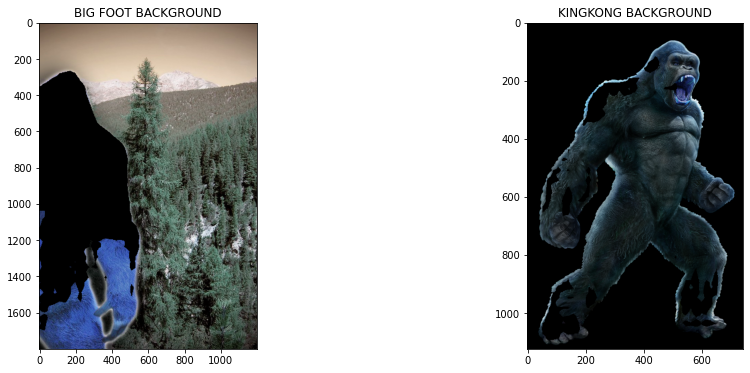

In [66]:
bigfoot_mask_color = cv2.cvtColor(bigfoot_mask_up, cv2.COLOR_GRAY2BGR)
bigfoot_bg_mask = cv2.bitwise_not(bigfoot_mask_color)
bigfoot_bg = cv2.bitwise_and(bigfoot_orig, bigfoot_bg_mask)

kingkong_mask_color = cv2.cvtColor(kingkong_mask_up, cv2.COLOR_GRAY2BGR)
kingkong_bg_mask = cv2.bitwise_not(kingkong_mask_color)
kingkong_bg = cv2.bitwise_and(kingkong_orig, kingkong_bg_mask)

fig = plt.figure(figsize=(16, 6)) 

ax = plt.subplot(1,2,1)
plt.imshow(bigfoot_bg, cmap=plt.cm.binary_r)
ax.set_title('BIG FOOT BACKGROUND')

ax = plt.subplot(1,2,2)
plt.imshow(kingkong_bg, cmap=plt.cm.binary_r)
ax.set_title('KINGKONG BACKGROUND')

plt.show()

## ㅋㅋㅋㅋ 내가 원한게 아니였는데 너무 웃기네..

# 가우시안 BLUUUURRR 사용하기

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


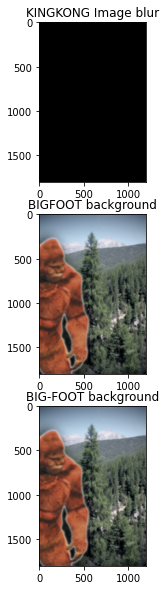

In [67]:
bigfoot_map = np.where(bigfoot_map == 10, 10, 0) 
bigfoot_mask = bigfoot_map * (255/bigfoot_map.max()) 
bigfoot_mask = bigfoot_mask.astype(np.uint8)

# 원본 사진과 마스크의 크기를 맞춰준다.
bigfoot_mask_up = cv2.resize(bigfoot_mask, bigfoot_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
# 채널을 원본 사진과 맞게 3 channel로 바꾼다.
bigfoot_mask_3C = np.repeat(np.expand_dims(bigfoot_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
bigfoot_orig_blur = cv2.GaussianBlur(bigfoot_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
bigfoot_Gmask = (cv2.GaussianBlur(bigfoot_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
bigfoot_image_blur = bigfoot_Gmask*bigfoot_orig.astype(np.float32)
# 1-마스크를 해주는 이유는 Blur 처리한 원본에서 배경만 뽑아내기 위해서이다.
bigfoot_bg_mask = (1-bigfoot_Gmask)*bigfoot_orig_blur.astype(np.float32)
out = (bigfoot_image_blur+bigfoot_bg_mask).astype(np.uint8)

fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(3,1,1)
plt.imshow(cv2.cvtColor(bigfoot_image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('KINGKONG Image blur')

ax = plt.subplot(3,1,2)
plt.imshow(cv2.cvtColor(bigfoot_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('BIGFOOT background')

ax = plt.subplot(3,1,3)
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))
ax.set_title('BIG-FOOT background')

plt.show()

#### RESULT:

##### 생각보다 이미지 마스크가 잘 활성화 되지가 않는다. 상대적으로 너무 안좋은 결과가 나온것같다. 마스크가 그냥 배경에 별란 차이를 못 준다. 